 # Проект: Обучение с учителем: качество модели

# Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.


«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и этот отдел поможет с прогнозами.


**Цель исследования**

Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Что нам известно**

В нашем распоряжении четыре датасета с данными, вот какая информация в них содержится:
    
    
**market_file.csv**


Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.


•	id — номер покупателя в корпоративной базе данных.

•	Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».

•	Тип сервиса — уровень сервиса, например «премиум» и «стандарт».

•	Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.

•	Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.

•	Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.

•	Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.

•	Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.

•	Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.

•	Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.

•	Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.

•	Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.

•	Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.


**market_money.csv**


Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.


•	id — номер покупателя в корпоративной базе данных.

•	Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.

•	Выручка — сумма выручки за период.


**market_time.csv**


Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.


•	id — номер покупателя в корпоративной базе данных.

•	Период — название периода, во время которого зафиксировано общее время.

•	минут — значение времени, проведённого на сайте, в минутах.


**money.csv**


Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.


•	id — номер покупателя в корпоративной базе данных.

•	Прибыль — значение прибыли.


**Ход исследования**
 
 - Подготовим данные: загрузим и изучим общую информацию из предоставленных датасетов;
 - предобработаем данные: обработаем пропущенные значения, найдем дубликаты, скорректируем типы данных;
 - проведем исследовательский анализ данных;
 - объединим таблицы;
 - проведем корреляционный анализ данных;
 - построим пайплайны, обучим четыре модели и выберем лучшую;
 - проведем анализ важности признаков;
 - проведем сегментацию покупателей;
 - сформулируем общий вывод.
 

Приступим к работе.

## Загрузка данных

На этом этапе загрузим библиотеки и инструменты.

In [47]:
!pip install -q --upgrade scikit-learn
!pip install -q matplotlib==3.7.3
!pip install -q --upgrade numba
!pip install -q --upgrade shap
!pip -q install phik

### Загрузим библиотеки и инструменты

In [48]:
import shap 
import pandas as pd
import numpy as np 
from scipy import stats as st 
import matplotlib.pyplot as plt
import seaborn as sns 
import sklearn


In [134]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix

import warnings
import phik
import shap
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
TEST_SIZE = 0.25

### Загрузим данные таблиц

Загрузим и прочтем данные из таблиц, посмотрим основную информацию.

In [50]:
#переименуем таблицы для удобства
market = pd.read_csv('/datasets/market_file.csv')
market_money = pd.read_csv('/datasets/market_money.csv')
time = pd.read_csv('/datasets/market_time.csv')
money = pd.read_csv('/datasets/money.csv', sep=';', decimal=",")

In [51]:
#посмотрим основную информацию
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [52]:
#посмотрим первые строки таблицы
market.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [53]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [54]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [55]:
time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [56]:
time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [57]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [58]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


В таблицах отсутствуют пропуски — количество значений в столбцах соответствует количеству строк.
Типы данных, на первый взгляд, адекватны содержимому столбцов.
Названия стоблцов нужно «причесать», их содержимое — проверить данные на явные и неявные дубликаты.

## Предобработка данных

На этом этапе переименуем столбцы, проверим дубликаты.

### Переименуем столбцы

In [59]:
#переименуем столбцы
market = market.rename(columns={'Покупательская активность':'активность',
                                'Тип сервиса':'сервис', 
                                'Разрешить сообщать':'рассылка', 
                                'Маркет_актив_6_мес':'актив_6_мес', 
                                'Маркет_актив_тек_мес':'актив_тек_мес', 
                                'Длительность':'длительность', 
                                'Акционные_покупки':'акции', 
                                'Популярная_категория':'категория', 
                                'Средний_просмотр_категорий_за_визит':'категорий_за_визит', 
                                'Неоплаченные_продукты_штук_квартал':'неоплачено_штук', 
                                'Ошибка_сервиса':'ошибки', 
                                'Страниц_за_визит':'страницы'})

 
market_money = market_money.rename(columns={'Период': 'период', 
                                  'Выручка': 'выручка'})

 
time = time.rename(columns={'Период':'период', 
                            'минут':'минуты'})

 
money = money.rename(columns={'Прибыль':'прибыль'})

#проверим, что получилось
market.columns, market_money.columns, time.columns, money.columns

(Index(['id', 'активность', 'сервис', 'рассылка', 'актив_6_мес',
        'актив_тек_мес', 'длительность', 'акции', 'категория',
        'категорий_за_визит', 'неоплачено_штук', 'ошибки', 'страницы'],
       dtype='object'),
 Index(['id', 'период', 'выручка'], dtype='object'),
 Index(['id', 'период', 'минуты'], dtype='object'),
 Index(['id', 'прибыль'], dtype='object'))

### Проверим явные дубликаты

In [60]:
market.duplicated().sum()  

0

In [61]:
market_money.duplicated().sum()  

0

In [62]:
time.duplicated().sum() 

0

In [63]:
money.duplicated().sum()  

0

In [64]:
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  1300 non-null   int64  
 1   активность          1300 non-null   object 
 2   сервис              1300 non-null   object 
 3   рассылка            1300 non-null   object 
 4   актив_6_мес         1300 non-null   float64
 5   актив_тек_мес       1300 non-null   int64  
 6   длительность        1300 non-null   int64  
 7   акции               1300 non-null   float64
 8   категория           1300 non-null   object 
 9   категорий_за_визит  1300 non-null   int64  
 10  неоплачено_штук     1300 non-null   int64  
 11  ошибки              1300 non-null   int64  
 12  страницы            1300 non-null   int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 132.2+ KB


In [65]:
# попутно приведем в приличный вид содержимое столбцов
cols = ['активность', 'сервис', 'рассылка', 'категория']
for i in cols:
    market[i] = market[i].str.lower()
    market[i] = market[i].str.replace(' ', '_') 

### Проверим неявные дубликаты

In [66]:
market['активность'].unique()

array(['снизилась', 'прежний_уровень'], dtype=object)

In [67]:
market['сервис'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

In [68]:
# нашлась явная опечатка
market['сервис'] = market['сервис'].replace('стандартт','стандарт')

In [69]:
market['сервис'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [70]:
market['рассылка'].unique()

array(['да', 'нет'], dtype=object)

In [71]:
market['категория'].unique()

array(['товары_для_детей', 'домашний_текстиль', 'косметика_и_аксесуары',
       'техника_для_красоты_и_здоровья', 'кухонная_посуда',
       'мелкая_бытовая_техника_и_электроника'], dtype=object)

In [72]:
# и  тут опечатка
market['категория'] = market['категория'].replace('косметика и аксесуары','косметика и аксессуары')

In [73]:
market['категория'].unique()

array(['товары_для_детей', 'домашний_текстиль', 'косметика_и_аксесуары',
       'техника_для_красоты_и_здоровья', 'кухонная_посуда',
       'мелкая_бытовая_техника_и_электроника'], dtype=object)

In [74]:
market_money['период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [75]:
time['период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [76]:
# о, и тут опечатка
time['период'] = time['период'].replace('предыдцщий_месяц','предыдущий_месяц')

In [77]:
time['период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

Мы провели необходимую предобработку данных: привели названия столбцов к змениному регистру, выяснили, что явных дубликатов нет, неявные — нашли и поправили.

## Исследовательский анализ данных

На этом шаге проведем исследовательский анализ данных из каждой таблицы и отберем клиентов с покупательской активностью не менее трёх месяцев — то есть таких, которые что-либо покупали в этот период.  

### Построим графики для таблицы market

In [78]:
# напишем функцию для построения гистограммы и диаграммы размаха для столбцов с количественными признаками
def hist_box(data, column):
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.xlabel(f'Значения столбца "{column}"')
    plt.ylabel('Частота')
    plt.title(f'Гистограмма для "{column}"')
    sns.histplot(data[column], color='MediumPurple')
    plt.subplot(1, 2, 2)
    plt.xlabel(f'Значения столбца {column}')
    plt.title(f'Диаграмма размаха для {column}')
    sns.boxplot(x=data[column], color='Indigo')

In [79]:
# выведем первые строки таблицы, чтобы все столбцы были перед глазами
market.head()

,id,активность,сервис,рассылка,актив_6_мес,актив_тек_мес,длительность,акции,категория,категорий_за_визит,неоплачено_штук,ошибки,страницы
0,215348,снизилась,премиум,да,3.4,5,121,0.00,товары_для_детей,6,2,1,5
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2


Сначала рассмотрим столбцы с дискретными данными — для них построим графики, которые на каждое уникальное значение признака строят отдельную корзину.

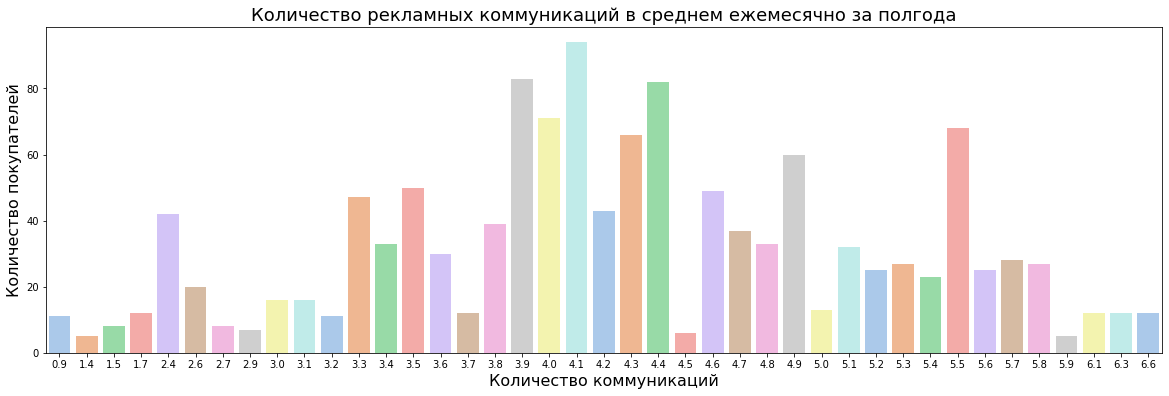

In [80]:
fig, axes = plt.subplots(figsize=(20,6))
plt.title('Количество рекламных коммуникаций в среднем ежемесячно за полгода', fontsize=18)
sns.countplot(x = 'актив_6_мес', data = market, palette='pastel')
plt.xlabel('Количество коммуникаций', fontsize=16)
plt.ylabel('Количество покупателей', fontsize=16)
plt.show()

Визуализация получилась на грани, потому что внушительная по размеру, но мы видим, что за последние полгода в среднем покупатели получали по 4-5 рекламных рассылок в месяц.

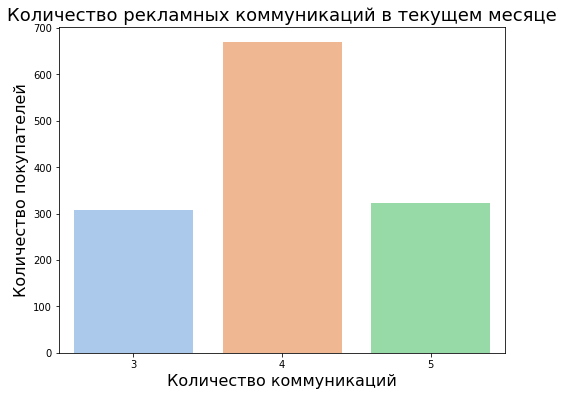

In [81]:
fig, axes = plt.subplots(figsize=(8,6))
plt.title('Количество рекламных коммуникаций в текущем месяце',fontsize=18)
sns.countplot(x = 'актив_тек_мес', data = market, palette='pastel')
plt.xlabel('Количество коммуникаций', fontsize=16)
plt.ylabel('Количество покупателей', fontsize=16)
plt.show()

Большая часть покупателей — почти 700 человек — получили четыре маркетинговых коммуникации в текущем месяце. 

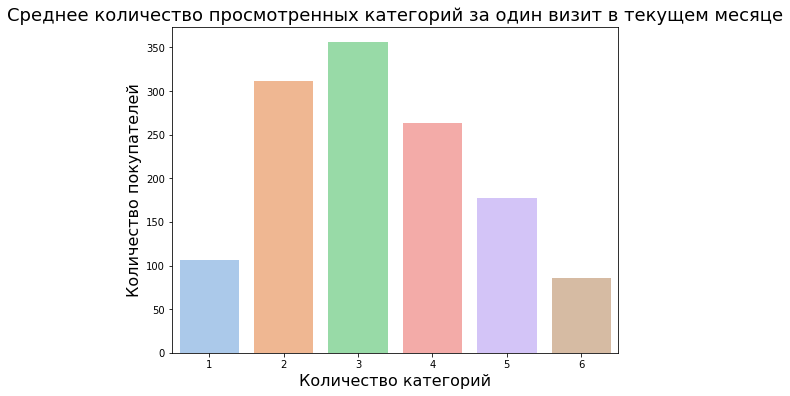

In [82]:
fig, axes = plt.subplots(figsize=(8,6))
plt.title('Среднее количество просмотренных категорий за один визит в текущем месяце',  fontsize=18)
sns.countplot(x = 'категорий_за_визит', data = market, palette='pastel')
plt.xlabel('Количество категорий', fontsize=16)
plt.ylabel('Количество покупателей', fontsize=16)
plt.show()

Лидирующее количество категорий, которые покупатели просматривают за один визит в рамках этого месяца — три или две. Очень слабый результат, эти люди совсем не умеют прокрастинировать.

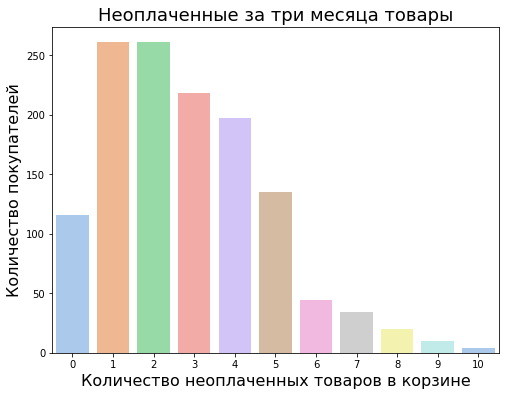

In [83]:
fig, axes = plt.subplots(figsize=(8,6))
plt.title('Неоплаченные за три месяца товары',  fontsize=18)
sns.countplot(x = 'неоплачено_штук', data = market, palette='pastel')
plt.xlabel('Количество неоплаченных товаров в корзине', fontsize=16)
plt.ylabel('Количество покупателей', fontsize=16)
plt.show()

За последние три месяца чаще всего в корзине оставались неоплаченными от одного до четырех товаров.

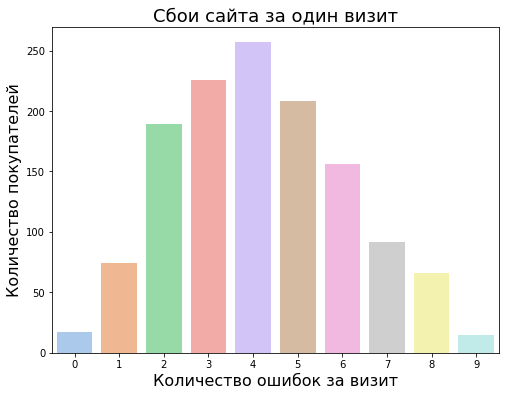

In [84]:
fig, axes = plt.subplots(figsize=(8,6))
plt.title('Сбои сайта за один визит',  fontsize=18)
sns.countplot(x = 'ошибки', data = market, palette='pastel')
plt.xlabel('Количество ошибок за визит', fontsize=16)
plt.ylabel('Количество покупателей', fontsize=16)
plt.show()

Если я правильно понимаю, сайт крашится часто — в среднем четыре раза за одно посещение. Это тревожный симптом, с этим нужно что-то делать.

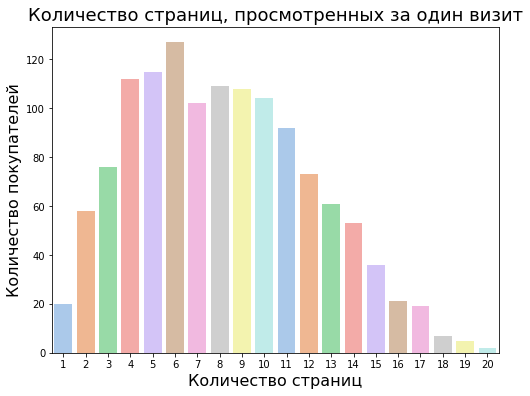

In [85]:
fig, axes = plt.subplots(figsize=(8,6))
plt.title('Количество страниц, просмотренных за один визит',  fontsize=18)
sns.countplot(x = 'страницы', data = market, palette='pastel')
plt.xlabel('Количество страниц', fontsize=16)
plt.ylabel('Количество покупателей', fontsize=16)
plt.show()

Лидирующее количество просмотренных страниц за один визит — шесть, но при этом чаще всего просматриваются три категории. Выглядит странно, но это может быть связано с падающим сайтом.

Теперь рассмотрим количественные признаки.

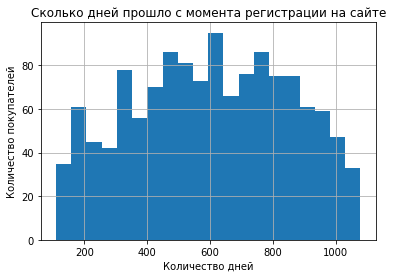

In [86]:
market['длительность'].hist(bins=20)
plt.title('Сколько дней прошло с момента регистрации на сайте')
plt.xlabel('Количество дней')
plt.ylabel('Количество покупателей')
plt.show()

Этот признак в целом распределен равномерно на всём диапазоне значений.

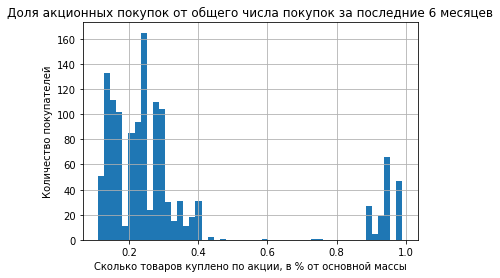

In [139]:
market['акции'].hist(bins=50)
plt.title('Доля акционных покупок от общего числа покупок за последние 6 месяцев')
plt.xlabel('Сколько товаров куплено по акции, в % от основной массы')
plt.ylabel('Количество покупателей')
plt.show()



In [140]:
market['акции'].describe()

count    1296.000000
mean        0.320069
std         0.249159
min         0.110000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акции, dtype: float64

Этот признак имеет бимодальное распределение: есть немалая доля покупателей, кто покупает только по акции. 

### Построим гистограммы для таблицы market_money

In [88]:
# обозначим количественный признак датасета market_money
num_col_market_money = ['выручка'] 

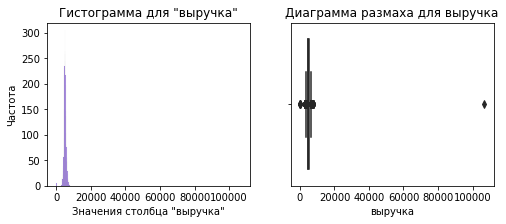

In [89]:
# построим распределение  
for name in num_col_market_money:
    hist_box(market_money, name)

In [90]:
# найдем выбросы
market_money.query('выручка > 20000')

,id,период,выручка
98,215380,текущий_месяц,106862.2


In [91]:
# удалим аномалию
market_money = market_money[market_money['выручка'] < 100000]

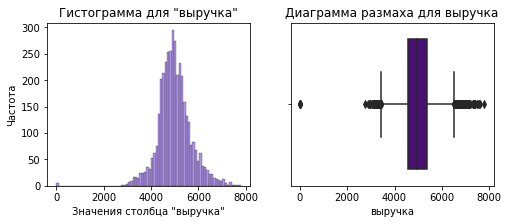

In [92]:
# построим распределение количественных признаков датасета market_money без выбросов
for name in num_col_market_money:
    hist_box(market_money, name)

In [93]:
# нашлись нулевые значения
market_money.query('выручка < 1')

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


Нашлись 6 пользователей с нулевой выручкой. Думаю, стоит удалить эти строчки — мы хотим в дальнейшем использовать данные только о тех пользователей, у которых есть активность за три месяца, а такие пустые записи явно нам помешают.

In [94]:
market_money = market_money[market_money['выручка'] > 0]

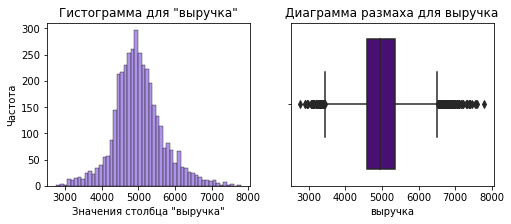

In [95]:
for name in num_col_market_money:
    hist_box(market_money, name)

Теперь распределение нормальное и видно, какую сумму пользователи оставляют в магазине чаще всего.

### Построим гистограммы для таблицы time

In [96]:
# обозначим количественный признак датасета m_money
num_col_time = ['минуты'] 

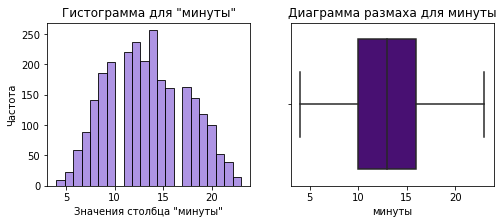

In [97]:
# построим распределение  
for name in num_col_time:
    hist_box(time, name)


Распределение нормальное, но на гистограмме видны два провала: большая часть посетителей проводят на сайте магазина от 10 до 16 минут.

### Построим гистограммы для таблицы money

In [98]:
# обозначим количественный признак датасета m_money
num_col_money = ['прибыль'] 

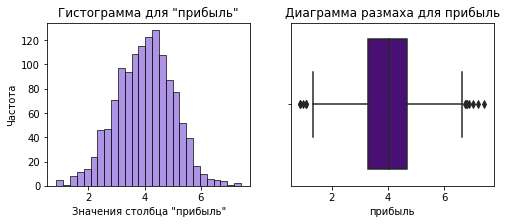

In [99]:
for name in num_col_money:
    hist_box(money, name)

Признак распределен нормально.

In [100]:
#создание функции для построения круговой диаграммы для категориальных признаков

def pie_graph(dataset, column, name, n, i):
    plt.subplot(1, n, i)
    plt.title(column)
    plt.pie(x=dataset.groupby(column)[name].count(),
            startangle=90,
            labeldistance=1.1, 
            wedgeprops={'linewidth':3, 'edgecolor':'white'}, 
            autopct='%1.1f%%',
            labels=dataset.groupby(column)[name].count().index, 
            colors=sns.color_palette('BuPu_r'))

### Оценим соотношение категориальных признаков

In [101]:
# посмотрим на категориальные признаки датасета market
cat_col_market = ['активность', 'сервис', 'рассылка', 'категория']

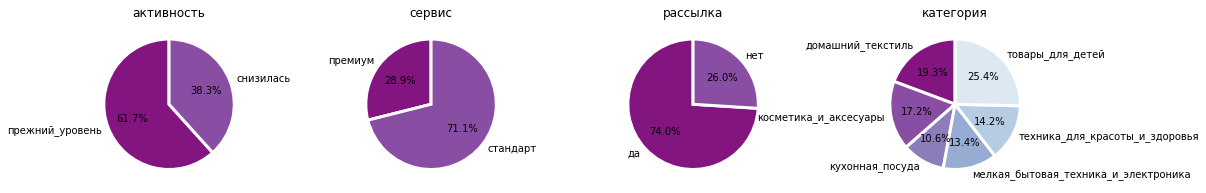

In [102]:
# построим круговые диаграммы
i = 1
plt.figure(figsize=(18,3))
for name in cat_col_market:
    pie_graph(market, name, 'id', len(cat_col_market), i)
    i += 1

Что на первый взгляд:
- активность снизилась меньше чем у половины пользователей;
- практически 3/4 пользователей предпочитают сервис стандартного уровня;
- почти 3/4 пользователей соглашаются на рассылку — например, чтобы не упустить оповещения об акциях;
- самыми популярными категориями за последние полгода стали детские товары, текстиль и косметика.

In [103]:
# посмотрим на категориальный признак датасета market_money
cat_col_market_money = ['период']

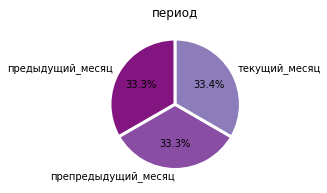

In [104]:
# построим круговую диаграмму
i = 1
plt.figure(figsize=(18,3))
for name in cat_col_market_money:
    pie_graph(market_money, name, 'id', len(cat_col_market_money), i)
    i += 1

Удивительно ровно распределился финансовый результат — одинаково в текущем и двух предыдущих месяцах.

In [105]:
# посмотрим на категориальный признак датасета time
cat_col_time = ['период']

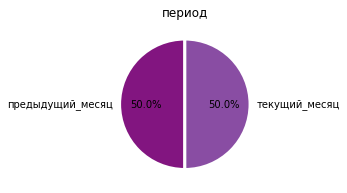

In [106]:
# построим круговую диаграмму
i = 1
plt.figure(figsize=(18,3))
for name in cat_col_time:
    pie_graph(time, name, 'id',len(cat_col_time), i)
    i += 1

В предыдущем и текущем месяцах покупатели провели одинаковое количество времени на сайте.

### Оценим покупательскую активность

Нужно отобрать клиентов с активностью не менее трех месяцов. Это значит, что нам нужны записи из market_money, где у клиента есть покупки за все три периода: 'препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'.

In [107]:
agg_dict = {'период': ['count']}
grouped = market_money.groupby('id').agg(agg_dict)
grouped.columns = ['count']

grouped = grouped[grouped['count'] == 3]
market = market[market['id'].isin(grouped.index)]
len(market)

1296

На этом шаге мы провели исследовательский анализ каждой из четырех таблиц, кое-где выявили и отбросили аномалии, а также оценили соотношение показателей и отобрали пользователей, активных в рамках трех месяцев.

## Объединение таблиц

Теперь объединим данные из датафреймов market, market_money, time в одну таблицу.

In [108]:
market_money_grouped = market_money.pivot_table(index=['id'], columns=["период"])
market_money_grouped.columns = ['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']
market_money_grouped['id'] = market_money_grouped.index

market_time_grouped = time.pivot_table(index=['id'], columns=["период"])
market_time_grouped.columns = ['минут_предыдущий_месяц', 'минут_текущий_месяц']
market_time_grouped['id'] = market_time_grouped.index

market_full = market.join(market_money_grouped, on='id', lsuffix="_left", rsuffix="_выручка")
market_full = market_full.rename(columns={'id_left':'id'})
market_full = market_full.join(market_time_grouped, on='id', lsuffix="_left", rsuffix="_минут")
market_full = market_full.rename(columns={'id_left':'id'})
market_full = market_full.drop(['id_выручка', 'id_минут'], axis=1)

#проверим, что получилось
market_full.head(5)

,id,активность,сервис,рассылка,актив_6_мес,актив_тек_мес,длительность,акции,категория,категорий_за_визит,неоплачено_штук,ошибки,страницы,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
5,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний_текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


Все нужные данные собраны в один датафрейм.

## Корреляционный анализ

Проведем корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделаем выводы о мультиколлинеарности и, при необходимости, устраним её.

### Построим матрицу 

In [109]:
#market_full = market_full.drop(['id'], axis=1)
# превратим столбец id в индекс датасета
market_full = market_full.set_index('id')

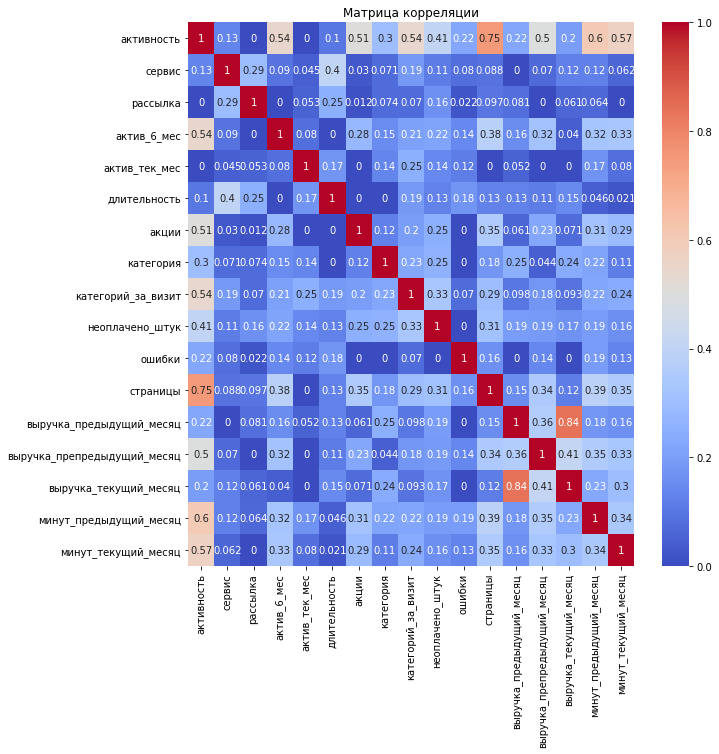

In [110]:
corr_matrix = market_full.phik_matrix(interval_cols=['актив_6_мес', 'длительность', 'акции', 'выручка_препредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц'])
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

### Проанализируем новую таблицу

В качестве целевого признака определим покупательскую активность, которая либо снизилась, либо осталась прежней у покупателей. Посмотрим, можно ли говорить о какой-то зависимости активности от остальных признаков.

Построим графики для анализа зависимости активности от дискретных признаков.

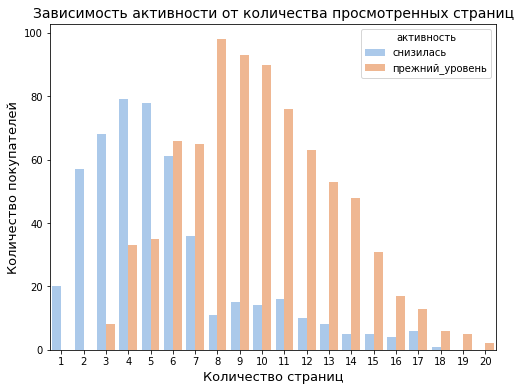

In [111]:
fig, axes = plt.subplots(figsize=(8,6))
plt.title('Зависимость активности от количества просмотренных страниц',  fontsize=14)
sns.countplot(x = 'страницы', data = market, palette='pastel', hue='активность')
plt.xlabel('Количество страниц', fontsize=13)
plt.ylabel('Количество покупателей', fontsize=13)
plt.show()

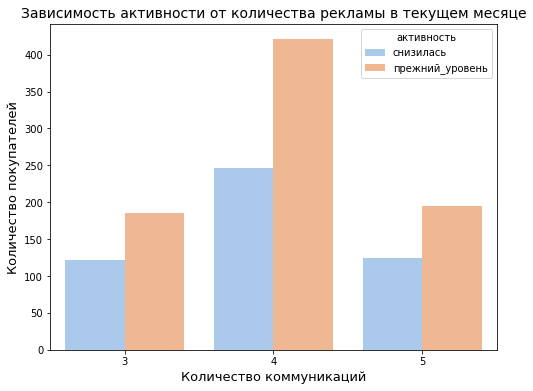

In [112]:
fig, axes = plt.subplots(figsize=(8,6))
plt.title('Зависимость активности от количества рекламы в текущем месяце',  fontsize=14)
sns.countplot(x = 'актив_тек_мес', data = market, palette='pastel', hue='активность')
plt.xlabel('Количество коммуникаций', fontsize=13)
plt.ylabel('Количество покупателей', fontsize=13)
plt.show()

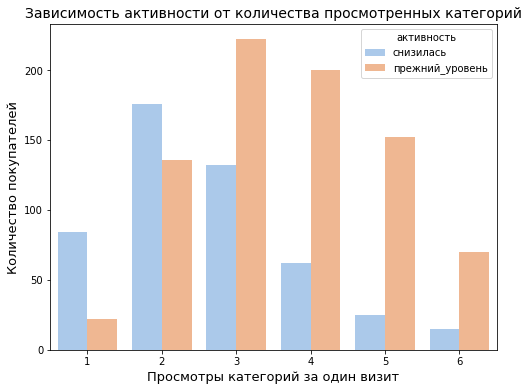

In [113]:
fig, axes = plt.subplots(figsize=(8,6))
plt.title('Зависимость активности от количества просмотренных категорий',  fontsize=14)
sns.countplot(x = 'категорий_за_визит', data = market, palette='pastel', hue='активность')
plt.xlabel('Просмотры категорий за один визит', fontsize=13)
plt.ylabel('Количество покупателей', fontsize=13)
plt.show()

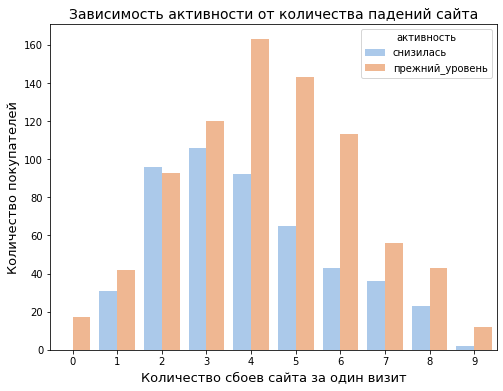

In [114]:
fig, axes = plt.subplots(figsize=(8,6))
plt.title('Зависимость активности от количества падений сайта',  fontsize=14)
sns.countplot(x = 'ошибки', data = market, palette='pastel', hue='активность')
plt.xlabel('Количество сбоев сайта за один визит', fontsize=13)
plt.ylabel('Количество покупателей', fontsize=13)
plt.show()

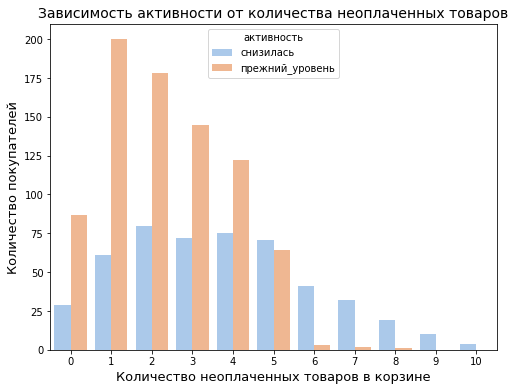

In [115]:
fig, axes = plt.subplots(figsize=(8,6))
plt.title('Зависимость активности от количества неоплаченных товаров',  fontsize=14)
sns.countplot(x = 'неоплачено_штук', data = market, palette='pastel', hue='активность')
plt.xlabel('Количество неоплаченных товаров в корзине', fontsize=13)
plt.ylabel('Количество покупателей', fontsize=13)
plt.show()

Теперь посмотрим, есть ли зависимость целевого признака от непрерывных.

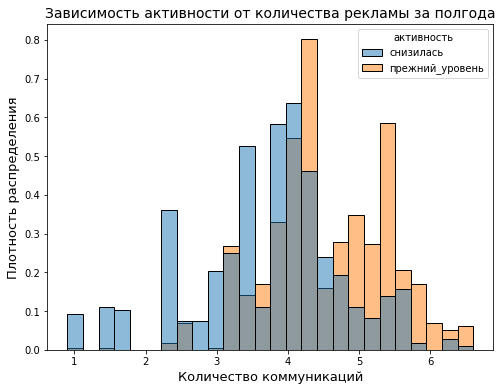

In [116]:
fig, axes = plt.subplots(figsize=(8,6))
plt.title('Зависимость активности от количества рекламы за полгода',  fontsize=14)
sns.histplot(stat='density', common_norm=False, data=market_full, x='актив_6_мес', hue='активность')
plt.xlabel('Количество коммуникаций', fontsize=13)
plt.ylabel('Плотность распределения', fontsize=13)
plt.show()

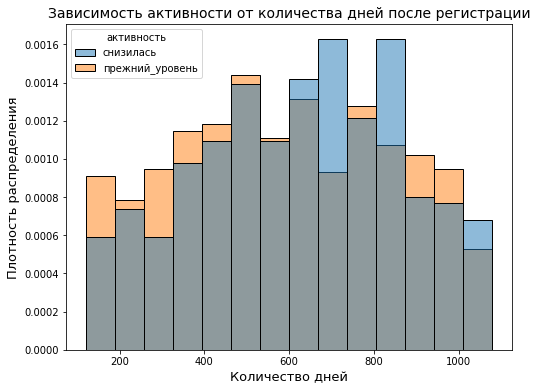

In [117]:
fig, axes = plt.subplots(figsize=(8,6))
plt.title('Зависимость активности от количества дней после регистрации',  fontsize=14)
sns.histplot(stat='density', common_norm=False, data=market_full, x='длительность', hue='активность')
plt.xlabel('Количество дней', fontsize=13)
plt.ylabel('Плотность распределения', fontsize=13)
plt.show()

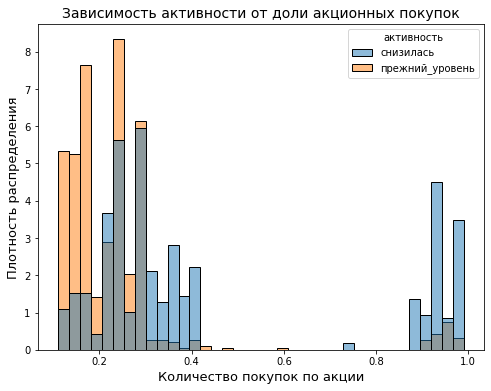

In [118]:
fig, axes = plt.subplots(figsize=(8,6))
plt.title('Зависимость активности от доли акционных покупок',  fontsize=14)
sns.histplot(stat='density', common_norm=False, data=market_full, x='акции', hue='активность')
plt.xlabel('Количество покупок по акции', fontsize=13)
plt.ylabel('Плотность распределения', fontsize=13)
plt.show()

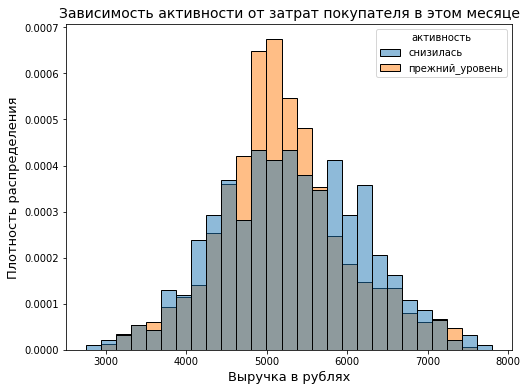

In [119]:
fig, axes = plt.subplots(figsize=(8,6))
plt.title('Зависимость активности от затрат покупателя в этом месяце',  fontsize=14)
sns.histplot(stat='density', common_norm=False, data=market_full, x='выручка_текущий_месяц', hue='активность')
plt.xlabel('Выручка в рублях', fontsize=13)
plt.ylabel('Плотность распределения', fontsize=13)
plt.show()

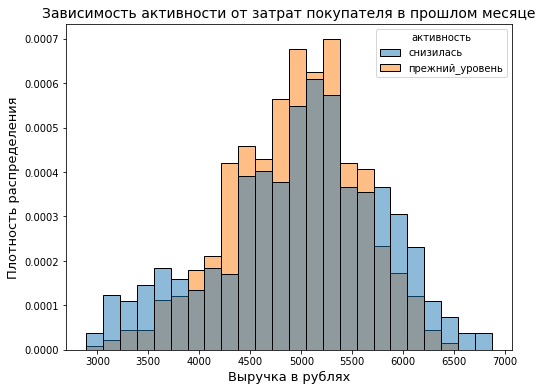

In [120]:
fig, axes = plt.subplots(figsize=(8,6))
plt.title('Зависимость активности от затрат покупателя в прошлом месяце',  fontsize=14)
sns.histplot(stat='density', common_norm=False, data=market_full, x='выручка_предыдущий_месяц', hue='активность')
plt.xlabel('Выручка в рублях', fontsize=13)
plt.ylabel('Плотность распределения', fontsize=13)
plt.show()

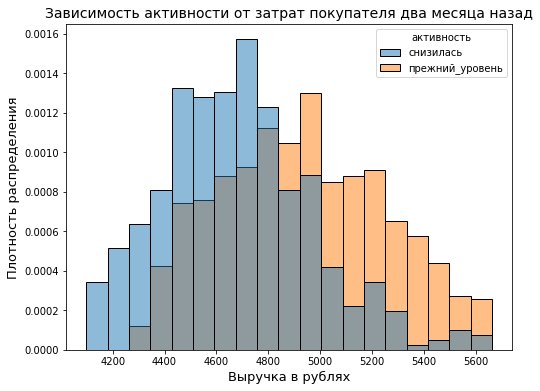

In [121]:
fig, axes = plt.subplots(figsize=(8,6))
plt.title('Зависимость активности от затрат покупателя два месяца назад',  fontsize=14)
sns.histplot(stat='density', common_norm=False, data=market_full, x='выручка_препредыдущий_месяц', hue='активность')
plt.xlabel('Выручка в рублях', fontsize=13)
plt.ylabel('Плотность распределения', fontsize=13)
plt.show()

Можно заметить, что распределение таких признаков как:
- категорий_за_визит,
- неоплачено_штук, 
- страницы, 
- минут_предыдущий_месяц,
- минут_текущий_месяц 
сильно различаются для покупателей с разной активностью.

Кроме того, плотность распределения признака **актив_6_мес** свидетельствует о том, что количество коммуникаций за полгода помогли не потерять в покупательской активности. Как именно интерпретировать распредление признака **длительность** мне не совсем понятно на данном этапе — кажется, что длительность и активность тут связаны естественным образом.
Что касается распределения признака **акции** — мы видим, что плотность распределения гораздо выше для покупателей, не снизивших активность и примерно пятую часть покупок совершивших по акциям.
Если говорить о распределении признаков, связанных с выручкой:
- в текущем и предыдущем месяцах при примерно равных объемах выручки куда выше плотность признака в области «активность осталась прежней»;
- в препредыдущем месяце покупатели со сниженной активностью «стартовали» с меньших сумм выручки, плотность распределения графика сниженной активности ниже, чем у графика неизменной активности, кривая распредлеления сниженной активности смещена влево.

Величины признаков  **категорий_за_визит**, **страницы**, **минут_предыдущий_месяц** и **минут_текущий_месяц** в среднем ниже у покупателей со сниженной активностью, чем у покупателей с прежним уровнем активности — это логично. 

Признак **неоплачено_штук** у покупателей со сниженной активностью в среднем выше, чем у покупателей с прежним уровнем активности.

Если говорить о корреляционном анализе — то, в целом, среди признаков замечена только одна сильная корреляция между признаками **выручка_предыдущий_месяц** и **выручка_текущий_месяц**, но значение корреляции куда меньше 0.9. Мультиколлинеарности не наблюдаем.

## Пайплайны

Применим все изученные модели. Для этого используем пайплайны. 

Во время подготовки данных используем ColumnTransformer. Количественные и категориальные признаки обработаем в пайплайне раздельно. 
 
Для проекта по Github обучим три модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() — и выберем лучшую.


### Подготовим данные

In [75]:
# превратим колонку Акционные_покупки в категориальный признак
# будем считать, что если человек больше половины покупок в месяц совершил по акции — он часто покупает по акции
market_full['акции_частота'] = market_full['акции']\
.apply( lambda x: 'часто_покупает_по_акции' if x>= 0.5 else 'редко_покупает_по_акции' )
market_full = market_full.drop(['акции'], axis=1)

In [76]:
market_full.head()

,активность,сервис,рассылка,актив_6_мес,актив_тек_мес,длительность,категория,категорий_за_визит,неоплачено_штук,ошибки,страницы,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,акции_частота
id,,,,,,,,,,,,,,,,,
215349,снизилась,премиум,да,4.4,4,819,товары_для_детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,часто_покупает_по_акции
215350,снизилась,стандарт,нет,4.9,3,539,домашний_текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,редко_покупает_по_акции
215351,снизилась,стандарт,да,3.2,5,896,товары_для_детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,часто_покупает_по_акции
215352,снизилась,стандарт,нет,5.1,3,1064,товары_для_детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,часто_покупает_по_акции
215353,снизилась,стандарт,да,3.3,4,762,домашний_текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,редко_покупает_по_акции


In [79]:
# разобьем данные, составим тренировочную и тестовую выборки
X = market_full.drop(['активность'], axis=1)
y = market_full['активность']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

In [80]:
# закодируем целевой признак «активность» в значение 0 и 1
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [81]:
# проверим
print(y_test)

[0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1 1 0 0 1 0 1 1 1 0 1 1 0 1 0 0 1 0
 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 1 0
 1 0 0 0 0 0 0 1 0 1 1 1 1 0 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 1 0 0 1 0 1 0
 0 0 0 1 1 0 1 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 1 1
 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0
 1 1 1 1 1 0 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 1 0 0 1 0 0
 0 0 0 0 1 1 1 0 0 0 0 1 1 1 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 1 0 1 1 0 0 1
 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 0 1 0 1]


In [82]:
X_train.head()

,сервис,рассылка,актив_6_мес,актив_тек_мес,длительность,категория,категорий_за_визит,неоплачено_штук,ошибки,страницы,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,акции_частота
id,,,,,,,,,,,,,,,,
215858,стандарт,да,5.5,4,510,мелкая_бытовая_техника_и_электроника,2,4,7,16,5170.5,4347.0,6014.2,20,6,редко_покупает_по_акции
215361,стандарт,да,5.1,4,199,техника_для_красоты_и_здоровья,4,5,2,3,6400.0,4597.0,3789.7,11,13,редко_покупает_по_акции
215884,стандарт,да,4.3,5,997,мелкая_бытовая_техника_и_электроника,5,1,3,11,4113.0,4626.0,3798.4,13,10,редко_покупает_по_акции
216564,стандарт,да,5.6,4,342,кухонная_посуда,2,7,5,8,4930.0,5269.0,4766.2,14,19,часто_покупает_по_акции
215715,премиум,да,3.6,5,873,товары_для_детей,3,2,2,5,3716.0,4691.0,4600.0,10,10,редко_покупает_по_акции


In [83]:
# создадим списки количественных и категориальных признаков
ohe_columns = ['категория']
ord_columns = ['акции_частота', 'сервис', 'рассылка']
num_columns = ['актив_6_мес',
               'актив_тек_мес',
               'длительность',
               'категорий_за_визит',
               'неоплачено_штук',
               'ошибки',
               'страницы', 
               'выручка_предыдущий_месяц',
               'выручка_препредыдущий_месяц', 
               'выручка_текущий_месяц', 
               'минут_предыдущий_месяц', 
               'минут_текущий_месяц']

### Закодируем данные и создадим пайплайн

In [84]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
)

In [85]:
ord_pipe = Pipeline(
    [
        (
            'simple_imputer_ord_before',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(categories=[
                                      ['стандарт', 'премиум'],
                                      ['редко_покупает_по_акции','часто_покупает_по_акции'],
                                      ['да', 'нет'],
                          ],
                          handle_unknown='use_encoded_value',
                          unknown_value=np.nan)
        ),
        (
            'simple_imputer_ord_after',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [86]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [87]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [ ]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 7),
        'models__max_features': range(2,7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    #{
        #'models': [SVC(random_state=RANDOM_STATE, kernel='poly', probability=True)],
        #'models__degree': range(2, 3),
        #'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    #}
]

Решено было выбрать метрику `ROC-AUC` и вот почему: 
- эта метрика хорошо подходит для оценки моделей, обученных на больших датасетах;
- мы анализировали непрерывные признаки в разреве целевого;
- эта метрика учитывает эффективность модели при различных пороговых значениях. Она является комплексной для оценки того, насколько хорошо разделяются случаи в разных группах, отображает истинную и постоянную способность модели к прогнозированию;
- в исследовании фигурирует бинарная классификация;
- AUC-ROC устойчива к несбалансированным классам.

In [89]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [90]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['категория']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simple_imputer_ord_before',
                                                                                                SimpleImputer(...
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(kernel='poly',
                                                        probability=True,
                                                        random_state=42)],
                                         'models__degree': range(2, 3),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [91]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', round(randomized_search.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simple_imputer_ord_before',
                                                                   SimpleImputer(strategy='most_frequent')),
              

In [92]:
# проверим работу модели на тестовой выборке
# рассчитаем прогноз на тестовых данных
y_test_pred = randomized_search.predict(X_test)
y_test_proba = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_test_proba[:,1]), 2)}')

Метрика ROC-AUC на тестовой выборке: 0.91


А теперь выведем метрику F1 на тестовой выборке:

In [93]:
print(f'Метрика F1-score на тестовой выборке: {round(f1_score(y_test, y_test_pred), 2)}')

Метрика F1-score на тестовой выборке: 0.83


### Сравним с константной моделью 

In [94]:
# загрузим инструмент, проведем сплитование
#from sklearn.dummy import DummyClassifier

In [246]:
# создадим и обучим DummyClassifier на тренировочных данных
# выполним предсказание на тестовой выборке
dummy_model = DummyClassifier(random_state=RANDOM_STATE)
dummy_model.fit(X_train, y_train)
dummy_model_preds = dummy_model.predict(X_test)
dummy_model_probas = dummy_model.predict_proba(X_test)[:,1]

In [247]:
# посчитаем и выведем метрику accuracy
dummy_acc = accuracy_score(y_test, dummy_model_preds)
print('Dummy Accuracy =', round(dummy_acc,2))


Dummy Accuracy = 0.62


In [248]:
# посчитаем и выведем метрику ROC-AUC
dummy_roc = roc_auc_score(y_test, dummy_model_probas)
print('ROC-AUC =', round(dummy_roc,2))

ROC-AUC = 0.5


In [249]:
# посчитаем и выведем F1-меру
dummy_f1 = f1_score(y_test, dummy_model_preds, pos_label='прежний_уровень')
print('F1-score =', round(dummy_f1,2))

F1-score = 0.77


Результат константной модели хуже результата тестирования нашей модели на тестовой выборке — наша модель хороша и имеет право на существование. 

На этом шаге были обучены три модели машинного обучения и выбрана лучшая — ею оказалась LogisticRegression. Мы использовали один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который вернул нам лучшую модель. Выбирали модель с помощью метрики ROC-AUC: показатели очень хорошие, наша модель хорошо справляется с предсказанием. Так же метрика f1 показала и вовсе фантастические 0.9.
 

## Анализ важности признаков

Оценим значение разных признаков в рамках обучения лучшей модели и построим график важности с помощью метода SHAP.

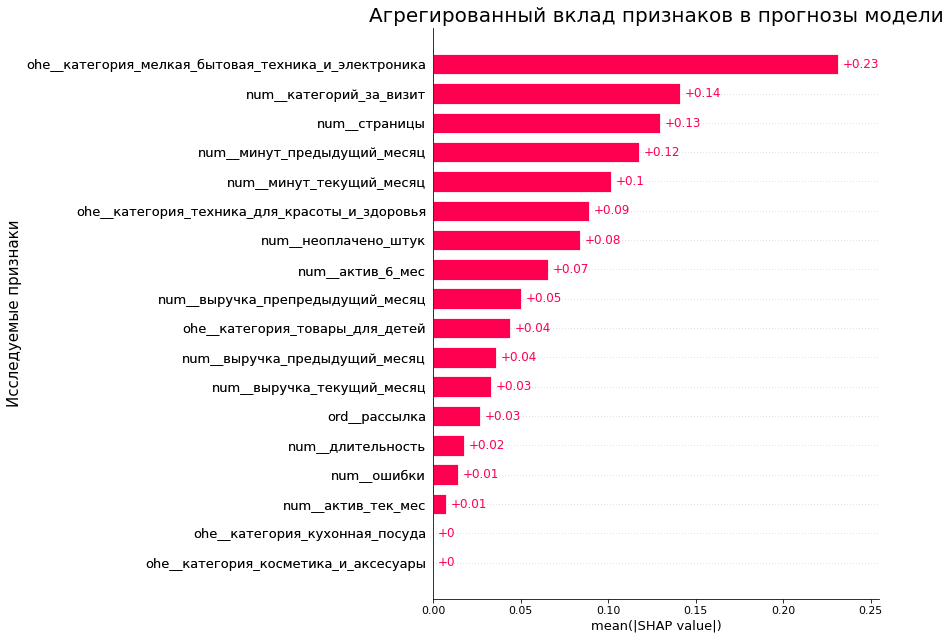

In [100]:
X_train_2 = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
explainer = shap.LinearExplainer(randomized_search.best_estimator_.named_steps['models'], X_train_2)

X_test_2 = pipe_final.named_steps['preprocessor'].transform(X_test)

feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()

X_test_2 = pd.DataFrame(X_test_2, columns=feature_names)
 
shap_values = explainer(X_test_2)

fig, ax = plt.gcf(), plt.gca() 
ax.set_title('Агрегированный вклад признаков в прогнозы модели', fontsize=20)
ax.set_ylabel('Исследуемые признаки', fontsize=15)
shap.plots.bar(shap_values, max_display=20)

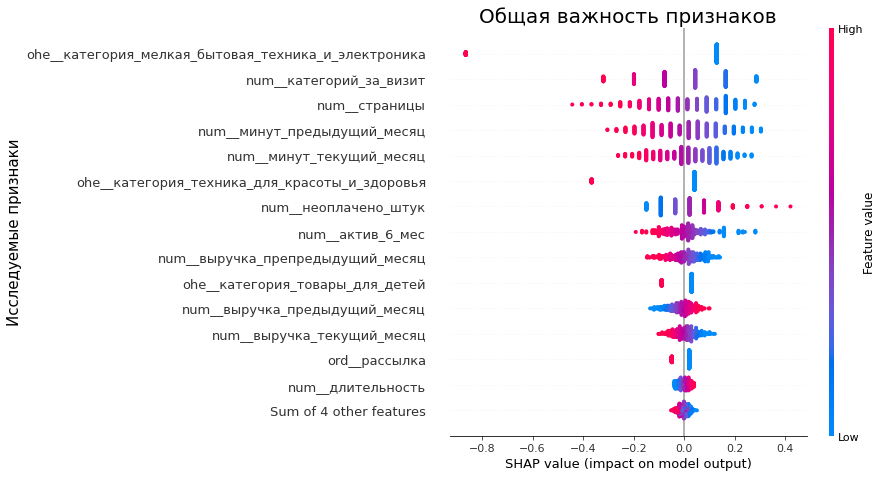

In [101]:
fig, ax = plt.gcf(), plt.gca() 
ax.set_title('Общая важность признаков', fontsize=20)
ax.set_ylabel('Исследуемые признаки', fontsize=15)
shap.plots.beeswarm(shap_values, max_display=15)

Что же мы видим: самые важные для модели признаки — это частота участий в акциях, конкретная категория «Мелкая бытовая техника», количество просмотренных категорий за визит, среднее количество просмотренных страниц за визит и количество минут, проведенных на сайте в предыдущем и текущем месяцах. 
Выходит, что выручка в предыдущем месяце и согласие на рассылку минимально влияют на целевой признак.
Какие рекомендации можно дать: 
- разумнее подходить к подбору акций и товаров, участвующих в них: нельзя привлекать людей только скидками;
- следует присмотреться к товарным катгориям, участвующих в акциях;
- может быть, стоит подумать об обогащении UX-ресурса: можно сделать сайт более привлекательным, чтобы был соблазн провести на нем больше времени;
- если количество просмотренных категорий важно — стоит поработать опять же над сайтом и, например, добавить подборки в духе «вместе с этим покупают», «вы это смотрели», «скоро закончится», «вам подойдет».

## Сегментация покупателей

Выполним сегментацию покупателей. На этом шаге используем результаты моделирования и данные о прибыли, которую приносят конкретные покупатели.

### Дополним датасет

In [102]:
y_test_proba = randomized_search.predict_proba(X_test)[:,1]
y_train_proba = randomized_search.predict_proba(X_train)[:,1]

In [103]:
X_test.head(3)

,сервис,рассылка,актив_6_мес,актив_тек_мес,длительность,категория,категорий_за_визит,неоплачено_штук,ошибки,страницы,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,акции_частота
id,,,,,,,,,,,,,,,,
216161,стандарт,да,4.1,4,606,техника_для_красоты_и_здоровья,6,1,4,12,3973.0,4912.0,3289.2,16,17,редко_покупает_по_акции
215654,премиум,нет,1.4,4,684,товары_для_детей,3,6,1,6,3548.0,4656.0,4170.7,11,9,часто_покупает_по_акции
216307,премиум,да,3.3,4,488,домашний_текстиль,4,2,8,10,5444.0,4565.0,6335.8,20,11,редко_покупает_по_акции


In [104]:
# добавим в датасет столбец с информацией о вероятности снижения активности пользователей 
X_test_full = X_test.copy()
X_train_full = X_train.copy()
X_test_full['вероятность_снижения'] = y_test_proba
X_train_full['вероятность_снижения'] = y_train_proba
df_full = pd.concat([X_train_full, X_test_full])

money = money.set_index('id')
df_full = df_full.join(money)

In [105]:
df_full.head(5)

,сервис,рассылка,актив_6_мес,актив_тек_мес,длительность,категория,категорий_за_визит,неоплачено_штук,ошибки,страницы,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,акции_частота,вероятность_снижения,прибыль
id,,,,,,,,,,,,,,,,,,
215858,стандарт,да,5.5,4,510,мелкая_бытовая_техника_и_электроника,2,4,7,16,5170.5,4347.0,6014.2,20,6,редко_покупает_по_акции,0.070758,4.37
215361,стандарт,да,5.1,4,199,техника_для_красоты_и_здоровья,4,5,2,3,6400.0,4597.0,3789.7,11,13,редко_покупает_по_акции,0.824209,4.03
215884,стандарт,да,4.3,5,997,мелкая_бытовая_техника_и_электроника,5,1,3,11,4113.0,4626.0,3798.4,13,10,редко_покупает_по_акции,0.095857,4.37
216564,стандарт,да,5.6,4,342,кухонная_посуда,2,7,5,8,4930.0,5269.0,4766.2,14,19,часто_покупает_по_акции,0.378275,5.58
215715,премиум,да,3.6,5,873,товары_для_детей,3,2,2,5,3716.0,4691.0,4600.0,10,10,редко_покупает_по_акции,0.783782,4.87


### Проверим зависимость между новыми и старыми признаками

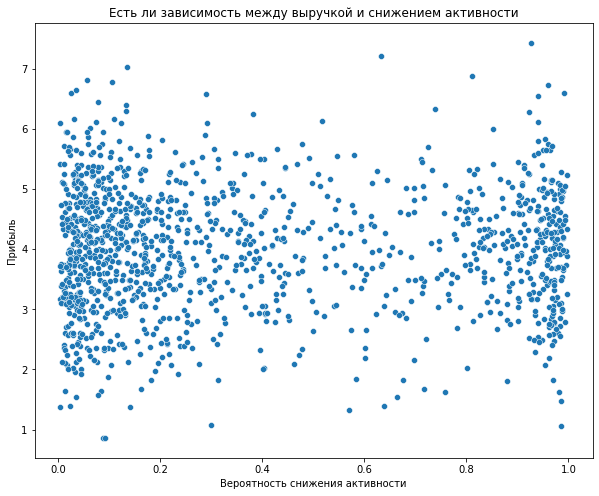

In [106]:
# построим диграмму рассеяния для признаков Прибыль и Вероятность снижения активности
fig = plt.figure(figsize=(10,8))
sns.scatterplot(data=df_full, y='прибыль', x='вероятность_снижения')
plt.xlabel('Вероятность снижения активности')
plt.ylabel('Прибыль')
plt.title('Есть ли зависимость между выручкой и снижением активности')
plt.show()

На первый взгляд, зависимости нет. Посмотрим, что покажут категориальные признаки на такой же диаграмме.

In [107]:
def build_scatterplots(cat_columns):
    for cat_col in cat_columns:
        fig = plt.figure(figsize=(10,8))
        sns.scatterplot(data=df_full, y='прибыль', x='вероятность_снижения', hue=cat_col)
        plt.xlabel('Вероятность снижения активности')
        plt.ylabel('Прибыль')
        plt.title('Есть ли зависимость между выручкой и снижением активности')
        plt.show()

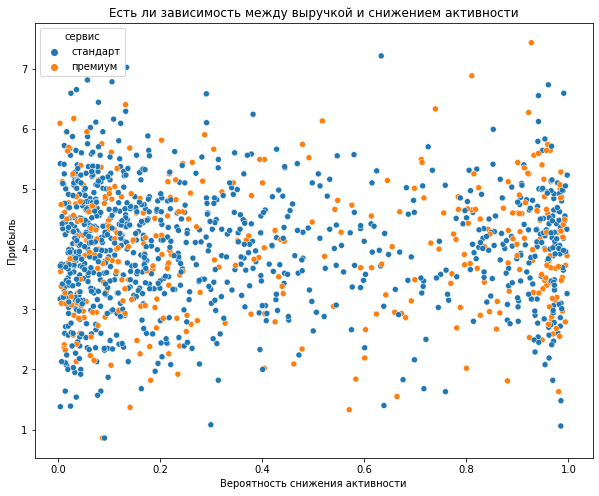

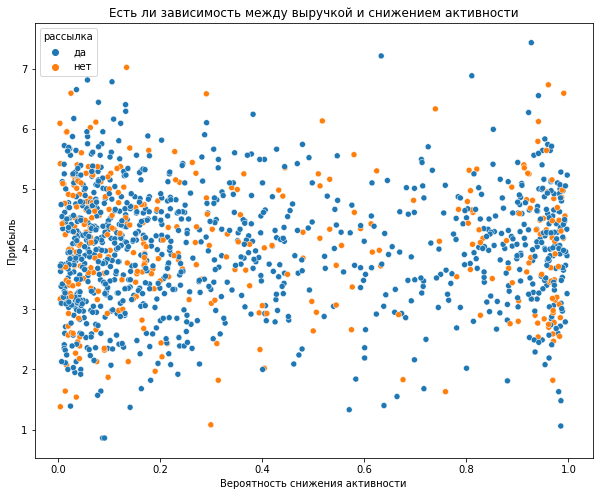

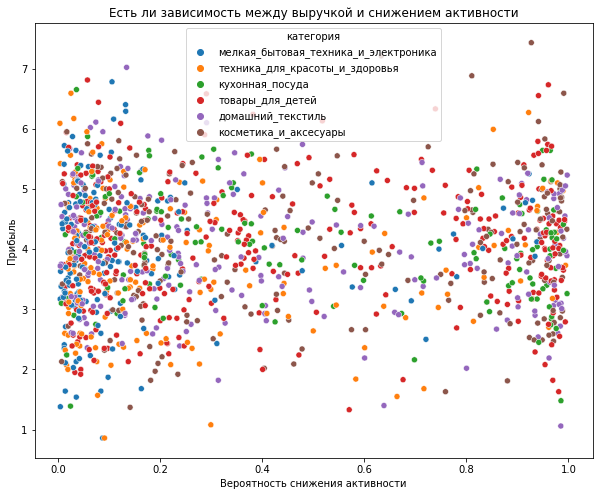

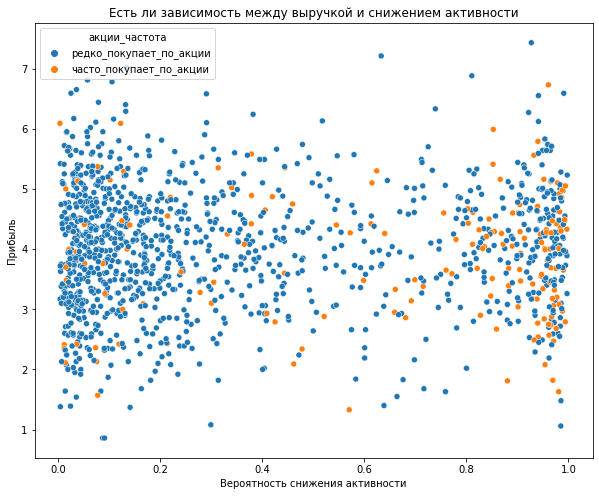

In [108]:
cat_columns = list(df_full.select_dtypes(include='object').columns)
build_scatterplots(cat_columns)

Явной зависимости снижения активности от таких признаков, как согласие на рассылку, приверженность определенному уровню сервиса или предпочтения по категориям не наблюдаем. Но зато видим, что люди, которые тяготеют к акционным покупкам, склонны к тому, чтобы резко терять активность и пропадать с радаров любимого сайта, если акций нет — это логично. На диграмме видно, что пользователи — любители акций равномерно «распределены» по всей оси прибыли. 

Попробуем проанализировать этот сегмент. Добавим в датасет столбец и в нем отметим пользователей, которые часто покупают по акции и имеют вероятность снижения активности более 80%.

### Проведем сегментацию

In [109]:
df_full.head(4)

,сервис,рассылка,актив_6_мес,актив_тек_мес,длительность,категория,категорий_за_визит,неоплачено_штук,ошибки,страницы,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,акции_частота,вероятность_снижения,прибыль
id,,,,,,,,,,,,,,,,,,
215858,стандарт,да,5.5,4,510,мелкая_бытовая_техника_и_электроника,2,4,7,16,5170.5,4347.0,6014.2,20,6,редко_покупает_по_акции,0.070758,4.37
215361,стандарт,да,5.1,4,199,техника_для_красоты_и_здоровья,4,5,2,3,6400.0,4597.0,3789.7,11,13,редко_покупает_по_акции,0.824209,4.03
215884,стандарт,да,4.3,5,997,мелкая_бытовая_техника_и_электроника,5,1,3,11,4113.0,4626.0,3798.4,13,10,редко_покупает_по_акции,0.095857,4.37
216564,стандарт,да,5.6,4,342,кухонная_посуда,2,7,5,8,4930.0,5269.0,4766.2,14,19,часто_покупает_по_акции,0.378275,5.58


In [110]:
# добавим столбец, в котором отметим, наш ли «клиент» пользователь или нет
df_full['сегмент'] = df_full\
.apply( lambda row: 'исследуемый_сегмент' \
        if row['вероятность_снижения'] > 0.8 and row['акции_частота']=='часто_покупает_по_акции' \
        else 'остальные_пользователи' \
      , axis=1)

In [111]:
# посмотрим, что получилось  
df_full['сегмент'].unique() 
print(df_full['сегмент'].value_counts())

остальные_пользователи    1201
исследуемый_сегмент         95
Name: сегмент, dtype: int64


In [112]:
# 114 человек имеют вероятность резко потерять интерес к покупкам
# создадим новый датафрейм и вынесем туда часть предыдущего — но только те строки, в которых нужные нам люди
df_invest=df_full.query('сегмент == "исследуемый_сегмент"') 

In [113]:
df_invest.head()

,сервис,рассылка,актив_6_мес,актив_тек_мес,длительность,категория,категорий_за_визит,неоплачено_штук,ошибки,страницы,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,акции_частота,вероятность_снижения,прибыль,сегмент
id,,,,,,,,,,,,,,,,,,,
215732,стандарт,нет,3.5,4,663,косметика_и_аксесуары,3,6,4,3,5810.0,4955.0,5772.3,16,11,часто_покупает_по_акции,0.850611,3.51,исследуемый_сегмент
215537,премиум,да,3.9,4,705,косметика_и_аксесуары,3,3,7,4,6121.5,4974.0,6781.9,7,9,часто_покупает_по_акции,0.880379,1.81,исследуемый_сегмент
215741,стандарт,да,4.8,4,563,товары_для_детей,1,5,7,4,3960.0,4809.0,4594.4,10,14,часто_покупает_по_акции,0.854780,4.29,исследуемый_сегмент
215408,премиум,да,2.4,3,666,кухонная_посуда,3,5,1,2,5295.0,4434.0,5029.8,10,12,часто_покупает_по_акции,0.975303,3.68,исследуемый_сегмент
215712,премиум,да,3.5,4,794,кухонная_посуда,3,7,8,6,5383.5,4668.0,5955.5,12,10,часто_покупает_по_акции,0.904446,3.66,исследуемый_сегмент


In [114]:
# напишем функцию, которая построит графики с барплотами
def cat_unique(df, col):
    display(df[col].unique())
    
    plt.figure(figsize=(8,6))
    plot = sns.countplot(y=col, data=df)
    plot.set_title(f'Рапределение признака {col}', fontsize=16)
    plot.set_xlabel('Количество', fontsize=14)

array(['косметика_и_аксесуары', 'товары_для_детей', 'кухонная_посуда',
       'домашний_текстиль', 'техника_для_красоты_и_здоровья',
       'мелкая_бытовая_техника_и_электроника'], dtype=object)

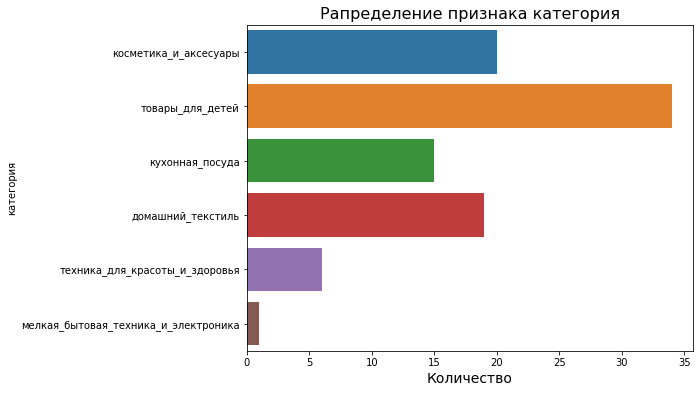

In [115]:
cat_unique(df_invest, 'категория')

Видим, что люди, которые любят по купать по акции товары для детей, имеют больше шансов потерять интерес. Это вполне логично: расходники для детей — вещь, пожирающая семейный бюджет и отсутствие акции на условные подгузники однозначно заставит экономного человека отправиться на поиски магазина, в котором акция будет.

array(['стандарт', 'премиум'], dtype=object)

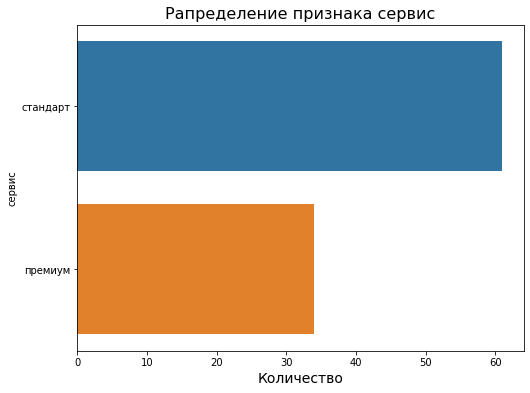

In [116]:
cat_unique(df_invest, 'сервис')

Люди, которые не стремятся получать сервис премиального уровня — более ветренные покупатели. Это тоже логично: если ты не связан с магазином подписками, спецобслуживанием, особой программой лояльности — проще уйти в другой магазин в поисках выгодных предложений. Люди же, имеющие вип-статус, склонны переплатить, но не дергаться.

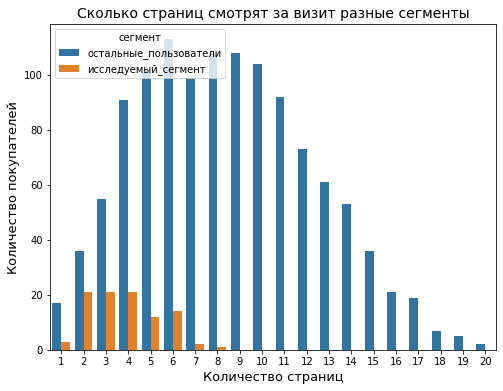

In [234]:
fig, axes = plt.subplots(figsize=(8,6))
plt.title('Сколько страниц смотрят за визит разные покупатели',  fontsize=14)
sns.countplot(x = 'страницы', data = df_full, hue='сегмент')
plt.xlabel('Количество страниц', fontsize=13)
plt.ylabel('Количество покупателей', fontsize=13)
plt.show()

Пользователи, которые выбирают скидки, просматривают меньше страниц — возможно, они точно знают, что ищут и не серфят по сайту. Быть может, они стеснены в средствах и потому не хотят тратить время на просмотр других товаров.

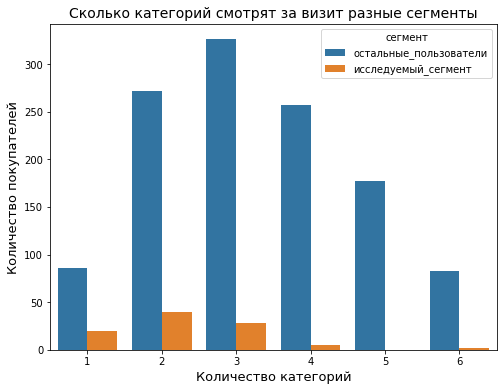

In [235]:
fig, axes = plt.subplots(figsize=(8,6))
plt.title('Сколько категорий смотрят за визит разные покупатели',  fontsize=14)
sns.countplot(x = 'категорий_за_визит', data = df_full, hue='сегмент')
plt.xlabel('Количество категорий', fontsize=13)
plt.ylabel('Количество покупателей', fontsize=13)
plt.show()

Исследуемый сегмент покупателей просматривает в целом столько же страниц, сколько и все остальные покупатели — просто нецелевых покупателей больше.

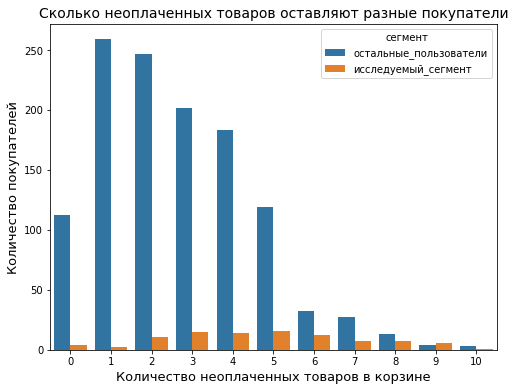

In [236]:
fig, axes = plt.subplots(figsize=(8,6))
plt.title('Сколько неоплаченных товаров оставляют разные покупатели',  fontsize=14)
sns.countplot(x = 'неоплачено_штук', data = df_full, hue='сегмент')
plt.xlabel('Количество неоплаченных товаров в корзине', fontsize=13)
plt.ylabel('Количество покупателей', fontsize=13)
plt.show()

Все пользователи оставляют неоплаченными в корзине примерно одинаковое количество товаров. 

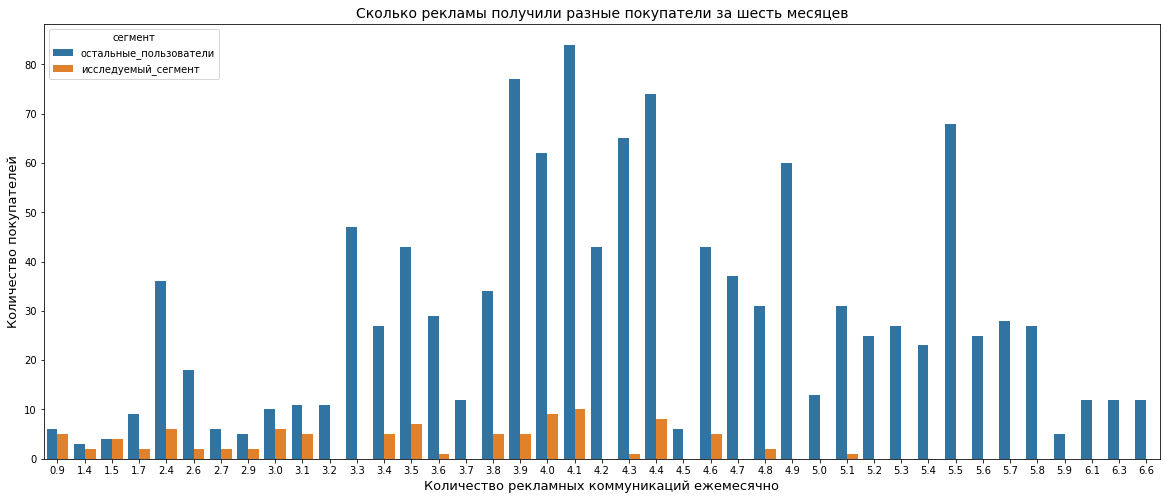

In [241]:
fig, axes = plt.subplots(figsize=(20,8))
plt.title('Сколько рекламы получили разные покупатели за шесть месяцев',  fontsize=14)
sns.countplot(x = 'актив_6_мес', data = df_full, hue='сегмент')
plt.xlabel('Количество рекламных коммуникаций ежемесячно', fontsize=13)
plt.ylabel('Количество покупателей', fontsize=13)
plt.show()

Кажется, что за полгода в среднем ежемесячно нецелевые покупатели получали больше рекламных коммуникаций, чем целевые.

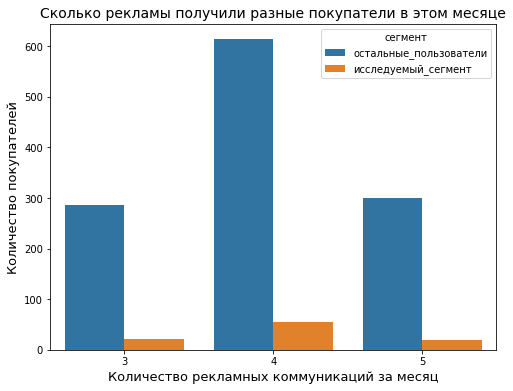

In [240]:
fig, axes = plt.subplots(figsize=(8,6))
plt.title('Сколько рекламы получили разные покупатели в этом месяце',  fontsize=14)
sns.countplot(x = 'актив_тек_мес', data = df_full, hue='сегмент')
plt.xlabel('Количество рекламных коммуникаций за месяц', fontsize=13)
plt.ylabel('Количество покупателей', fontsize=13)
plt.show()

Кажется, что любители акций в текущем получали такое же количество внимания от маркетплейса, как и все остальные пользователи: магазин не прилагал усилий, чтобы привести больше покупателей из исследуемого нами сегмента. 

Итак, для более углубленного исследования были выбраны пользователи, склонные покупать по акции и с «подвижной» покупательской активностью — к ним маркетплейсам нужно быть не менее внимательным, чем к випам.  

Чтобы снизить риски и подпитать активность таких покупателей (не потерять их внимание и не допустить оттока), можно использовать вот такие инструменты:

- выдавать больше персонализированных рассылок/пушей/смс («не закончились ли у вас товары», «в прошлый раз вы интересовались» — и тд);
- уделить больше внимания бесперебойным поставкам популярных категорий в нужном ценовом диапазоне;
- продумать варианты программ лояльности: предложить бесплатную доставку, бонусы, персональные скидки, промокоды, задания или лотереи, выбор льготных категорий в каждом месяце. Этот ход может перетянуть часть клиентов в зону «премиум», если логично построить переход из одной сферы сервиса в другую;
- для тех, кто не хочет тратить время на серфинг сайта, придумать подборки или тематические страницы;
- тем, кто оставляет неоплаченные товары в корзине, можно предлагать промокоды, действующие ограниченное количество времени;
- можно построить партнерскую программу с блогерами или какими-то другими лидерами мнений: предлагать им проводить стримы, записывать подкасты или распаковки. 

## Общий вывод

Итак, мы начали с того, что изучили данные о продажах и покупателях интернет-магазина «В один клик». Проблема заключается в том, что покупательская активность начала снижаться, несмотря на то, что ассортимент у магазина однозначно хитовый: детские товары, текстиль и косметика — три кита для мам в декрете, например. Нам нужно было проанализировать информацию из представленных датасетов и, руководствуясь уже согласованным планом, провести исследование, а затем — выдать рекомендации.

У нас в руках оказались данные о поведении покупателей на сайте, об активности в плане маркетинговых коммуникаций магазина и о выручке, которую покупатели приносят. 

Что мы сделали в рамках проекта:

- привели содержимое таблиц в консистентный и удобный для обработки вид;
- провери предобработку: проверили датасеты на наличие пропусков, явных дубликатов, исправили опечатки и неточности;
- провели исследовательский анализ — построили диаграммы и оценили данные с точки зрения раномерности распределения, местами удалили аномальные значения, которые явно не пригодились бы в дальнейшем;
- провели корреляционный анализ данных и признали признак «вероятность снижения активности» целевым;
- объединили таблицы в одну, чтобы на этих данных обучить модели и составить прогнозы;
- с использованием пайпланов обучили модели KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC(). При обучении моделей перебрали гиперпараметры и нашли модель, которая дала лучший результат;
- выяснили, что лучшей моделью оказалась LogisticRegression(C=2, penalty='l1', random_state=42, solver='liblinear');
- проанализировали важность разных признаков, влияющих на целевой — и поняли, что частота акционных покупок очень важна;
- провели сегментацию покупателей и выделили группу, поведение которой разобрали более подробно — исследуемым сегментом оказались любители акционных покупок;
- продумали рекомендации, которые можно выдать магазину, чтобы удержать целеыую группу пользователей и повысить их активность.



Выданные рекомендации преимущественно предполагают использование разных маркетинговых инструментов, которых сейчас в избытке — можно обратиться к опыту крупных маркетплейсов, например. Тезисно можно озвучить рекомендации вот так:

- больше внимания чувствительной группе покупателей;
- больше понимания их потребностей;
- больше стремления сделать процесс покупки и получения товаров удобным, быстрым, легким: сэкономленное время — это огромный ресурс.

Надеюсь, что эти рекомендации помогут магазину победить временные сложности и вырастить лояльность аудитории.